In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore_fraclap import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,-1,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
    def solve(self, forcing, noise_level = None, param = None):
        forcing_dict = {"F": forcing}
        scipy.io.savemat("forcing.mat", forcing_dict)
        
        matlab_path = "/Applications/MATLAB_R2022a.app/bin/matlab"
        os.system(f"{matlab_path} -nodisplay -nosplash -nodesktop -r \"run('solvefrac({int(param*10000)})'); exit;\" | tail -n +11")
        data = scipy.io.loadmat("solution.mat")
        solution = data['U']
        
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

In [3]:
%%time
add_noise = False
noise_level = 0.1

# paramSet = np.array([[1.0]])
paramSet = np.array([[0.6], [0.7], [0.8], [0.75]])
# paramSet = np.array([[0.92], [0.93], [0.95], [0.94]])

meshDensity = 2000
sigma = 0.005
rank = 200
nSamples = rank

Sim = Simulator(meshDensity)
models = []
for i, params in enumerate(paramSet):

    np.random.seed(42)

    print(f"Fractional Poisson (alpha = $ {params[0]}) | Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")

    meshweights = Sim.meshweights

    # Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
    forcing = sampleforcing(sigma, nSamples)
    if add_noise:
        solution = Sim.solve(forcing, noise_level, params[0])
    else:
        solution = Sim.solve(forcing, None, params[0])

    if add_noise:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = False)
    else:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = False)
        
    models.append(model)

Fractional Poisson (alpha = $ 0.6) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 200, rank: 200, Noise: False
Fractional Poisson (alpha = $ 0.7) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 200, rank: 200, Noise: False
Fractional Poisson (alpha = $ 0.8) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 200, rank: 200, Noise: False
Fractional Poisson (alpha = $ 0.75) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 200, rank: 200, Noise: False
CPU times: user 5.12 s, sys: 1.97 s, total: 7.09 s
Wall time: 7min 37s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
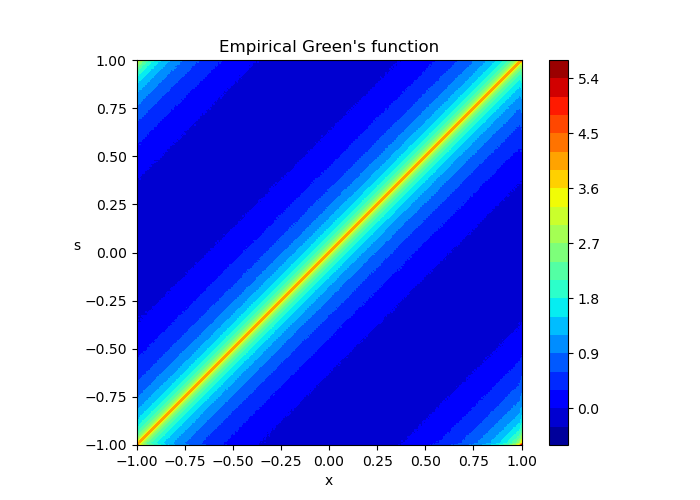

In [4]:
plotGreen1D(models[0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
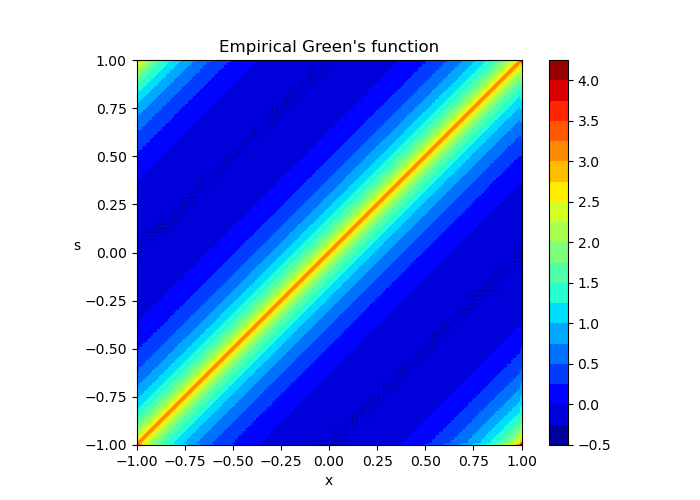

In [5]:
plotGreen1D(models[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
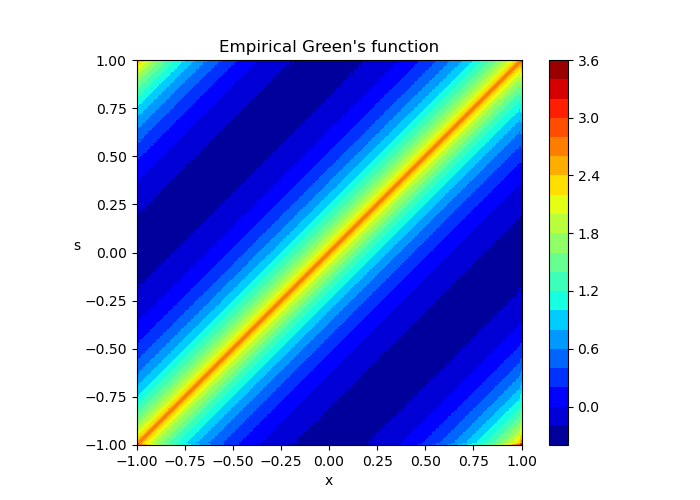

In [6]:
plotGreen1D(models[2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
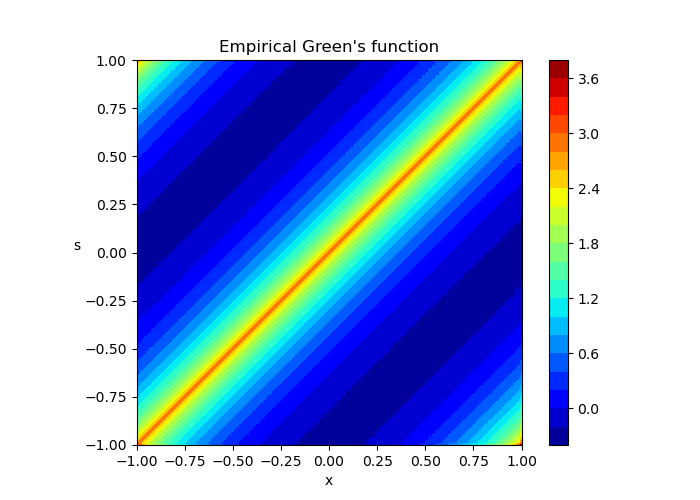

In [7]:
plotGreen1D(models[3])

In [8]:
def computeEmpiricalError(model, Sim, sigma, nSamples, noise_level = None):
    seed = 1
    np.random.seed(1)

    # Generate an forcing and output ensemble for testing
    forcing = sampleforcing(sigma, nSamples)
    if add_noise:
        solution = Sim.solve(forcing, noise_level, model.params[0])
    else:
        solution = Sim.solve(forcing, None, model.params[0])
    
    reconstruction = model.reconstruct_signal(forcing)
    
    error = np.zeros(nSamples)
    for i in range(nSamples):
        V = FunctionSpace(Sim.mesh, 'P', 1)
        d2v = dof_to_vertex_map(V)
        temp = Function(V)
        temp.vector()[:] = np.square(reconstruction[:,i] - solution[:,i])[d2v]
        num = assemble(temp*dx)
        temp.vector()[:] = np.square(solution[:,i])[d2v]
        den = assemble(temp*dx)
        
        error[i] = np.sqrt(num/den)
        
    return error

In [9]:
nSamples = 100
err = computeEmpiricalError(models[0], models[0].Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.020354740664477736
Mean error: 0.009698048936878851


In [10]:
nSamples = 100
err = computeEmpiricalError(models[1], models[1].Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.018830012054061932
Mean error: 0.008367311197351355


In [11]:
nSamples = 100
err = computeEmpiricalError(models[2], models[2].Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.017635911157979058
Mean error: 0.007704531683305011


Text(0.5, 0.98, 'Mode 7')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
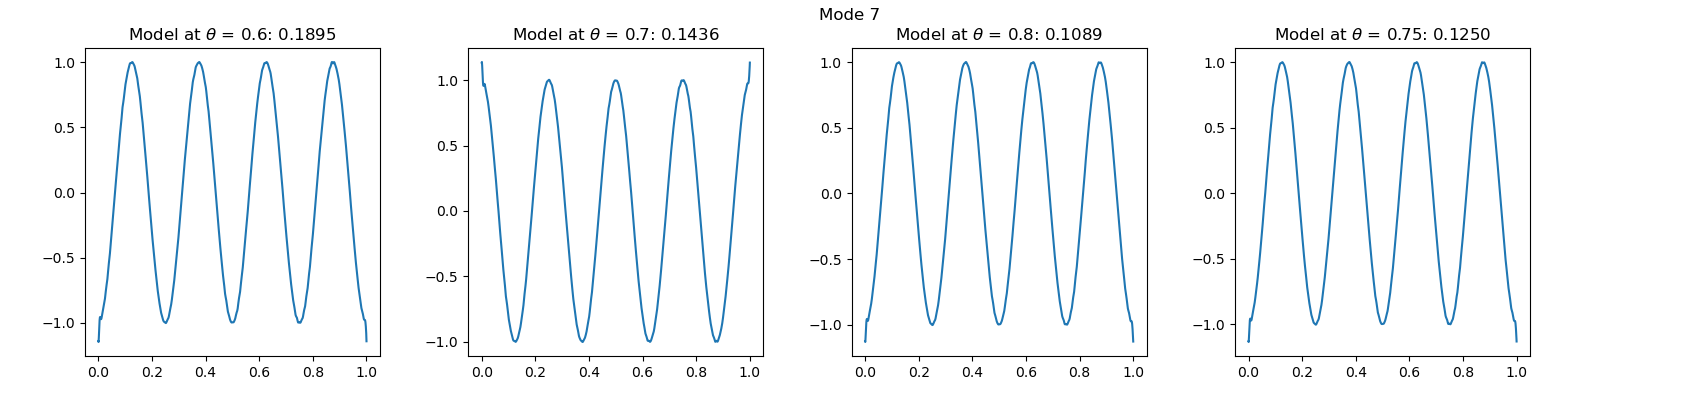

In [12]:
i = 7

plt.figure(figsize = (17,4))
plt.tight_layout()
x = np.linspace(0,1,2001)
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
for m in range(4):
    plt.subplot(1,4,m+1)
    mode = models[m].modeset[:,i]
    plt.plot(x,mode)
    plt.title(f'Model at $\\theta$ = {models[m].params[0]}: {models[m].dcoeffs[i,0]:.4f}')
    plt.subplot(1,4,m+1) 
plt.suptitle(f'Mode {i}')

In [ ]:
%%time

# Interpolation

print(f"Parameter set: {paramSet}")
interpSet = [models[0], models[1], models[2]]

targetParam = paramSet[-1]
targetModel = models[-1]

inputdata = models[-1].forcing #compute_forcing(pSim.mesh, numSteps)
simulator = Sim

interpModel, U_set, _ = model_interp(interpSet, simulator, inputdata, targetParam, verbose = False)

Parameter set: [[0.6 ]
 [0.7 ]
 [0.8 ]
 [0.75]]
CPU times: user 2.37 s, sys: 723 ms, total: 3.09 s
Wall time: 864 ms


Text(0.5, 1.0, 'Coefficients (S)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
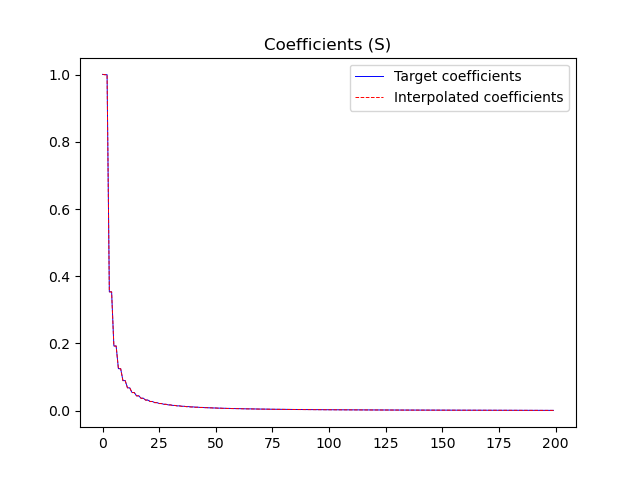

In [ ]:
plt.figure()
plt.plot(targetModel.dcoeffs,'b-', linewidth = 0.7, alpha = 1)
plt.plot(interpModel.dcoeffs,'r--', linewidth = 0.7, alpha = 1)
plt.legend(['Target coefficients','Interpolated coefficients'])
plt.title('Coefficients (S)')

Text(0.5, 1.0, 'Interpolated Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
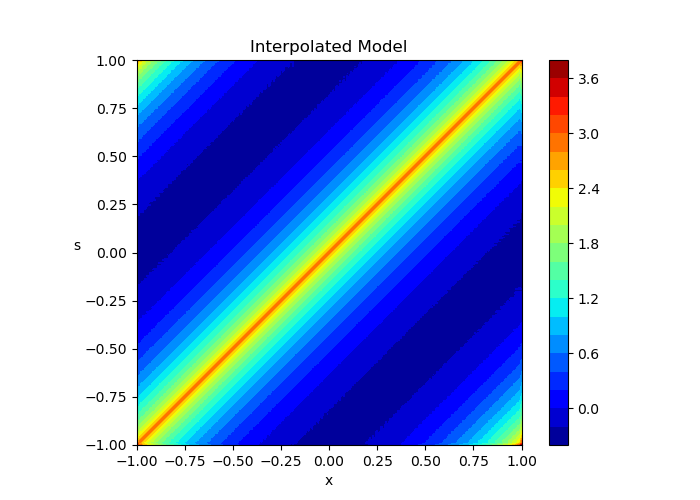

In [ ]:
plotGreen1D(interpModel)
plt.title('Interpolated Model')

Text(0.5, 1.0, 'Target Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
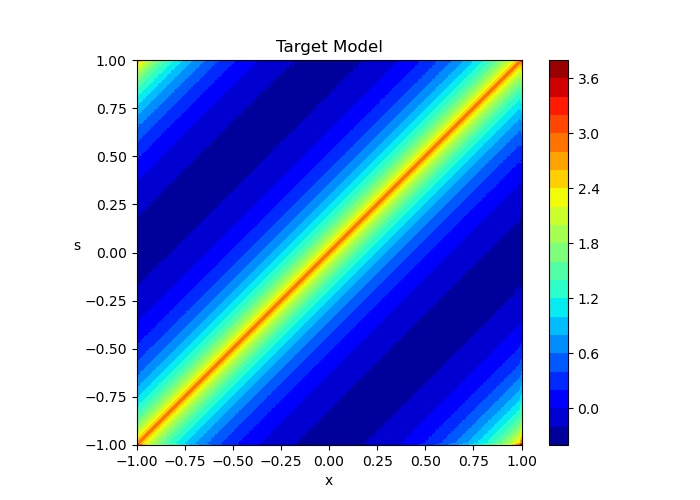

In [ ]:
plotGreen1D(targetModel)
plt.title('Target Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
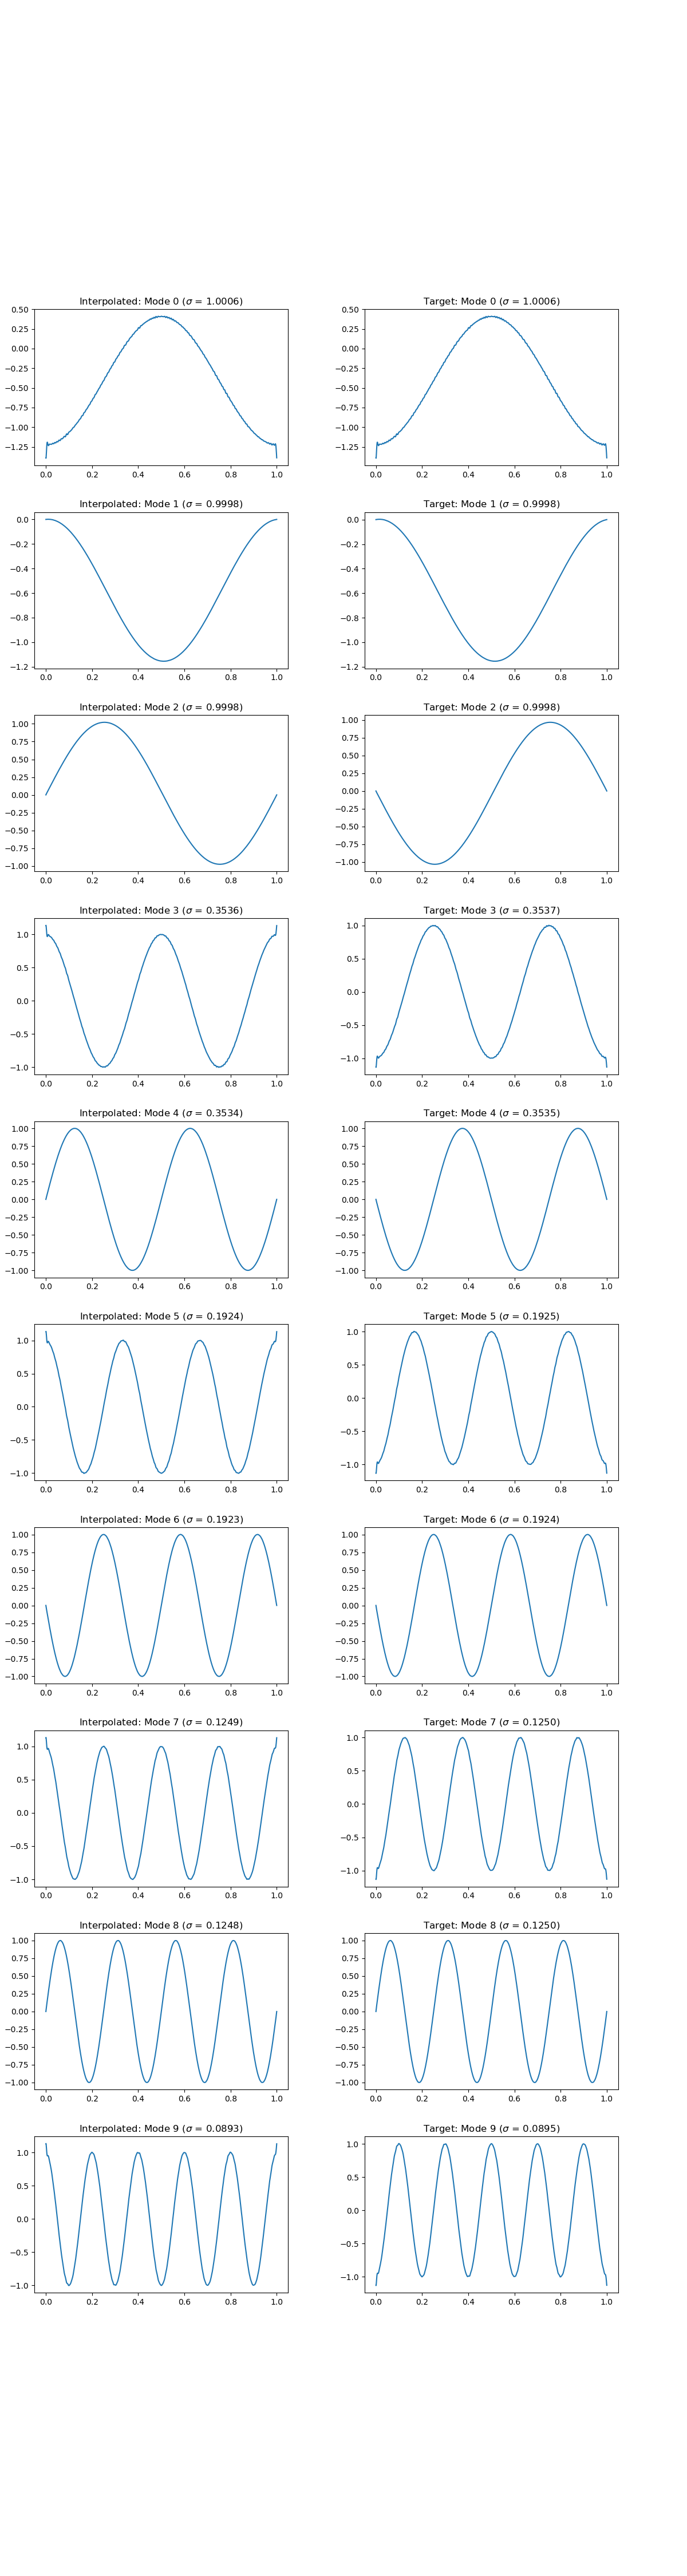

In [17]:
# i = 29

plt.figure(figsize = (12,4.5*10))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)

x = np.linspace(0,1,2001)
for i in range(10):
    plt.subplot(10,2,i*2+1)
    mode = interpModel.modeset[:,i]
    plt.plot(x,mode)
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Interpolated: Mode {i} ($\\sigma$ = {interpModel.dcoeffs[i]:.4f})')

    plt.subplot(10,2,2*i+2)
    mode = targetModel.modeset[:,i]
    plt.plot(x,mode)
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Target: Mode {i} ($\\sigma$ = {targetModel.dcoeffs[i,0]:.4f})')
# plt.suptitle(f'Models at $\\theta$ = {targetModel.params[0]/pi:.2f}')

In [21]:
Ginterp = reconstructEGF1D(interpModel)
Gtarget = reconstructEGF1D(targetModel)
error = errorL2(Ginterp, Gtarget, model.meshweights)

In [23]:
print(error)

0.001052492818310661


In [18]:
nSamples = 100
err = computeEmpiricalError(interpModel, Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.018202702182206605
Mean error: 0.008090272099002052
